# Classification of beats using a CNN model and the holdout beats validation protocol

In [1]:
# Imports:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import seaborn as sns
from sklearn import *
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

length = 277

### Extract task-specific data and one-hot encode labels

In [23]:
# Load the training and testing data:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('./train_beats.csv')
test_beats = glob.glob('./test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# Separate the training and testing data, and one-hot encode Y:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

X_train1 = X_train.reshape(-1, X_train.shape[1], 1)
X_test1 = X_test.reshape(-1, X_train.shape[1], 1)

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)

Loading  ./train_beats.csv
Loading  ./test_beats.csv
(31912, 277)
(37863, 277)


### Create a performance metrics function

In [4]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score_macro = f1_score(test, pred, average='macro') 
    f1score_micro = f1_score(test, pred, average='micro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score macro : {}".format(f1score_macro))
    print("f1score micro : {}".format(f1score_micro))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score_macro,3), 
            round(f1score_micro, 3), cm)

### Build the CNN architecture and train the model

In [7]:
tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 10, 64
activationFunction='relu'

def getModel():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=16,padding='same', activation='relu',input_shape=(X_train1.shape[1],X_train1.shape[2])))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=32, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=9, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=4,padding='same'))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(256, activation='relu'))
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(9, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = getModel()

cnnhistory= cnnmodel.fit(X_train1, y_train1, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)
cnnpredictions = cnnmodel.predict(X_test1, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 275, 128)          2176      
_________________________________________________________________
batch_normalization (BatchNo (None, 275, 128)          512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 275, 32)           65568     
_________________________________________________________________
batch_normalization_1 (Batch (None, 275, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 275, 9)            4617      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 69, 9)             0         
________________________________________________

C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


25529/25529 [==============================] - 35s 1ms/sample - loss: 0.3028 - accuracy: 0.9021 - val_loss: 0.3414 - val_accuracy: 0.8856
Epoch 2/10
25529/25529 [==============================] - 36s 1ms/sample - loss: 0.1155 - accuracy: 0.9624 - val_loss: 0.1073 - val_accuracy: 0.9684
Epoch 3/10
25529/25529 [==============================] - 36s 1ms/sample - loss: 0.0786 - accuracy: 0.9727 - val_loss: 0.1025 - val_accuracy: 0.9666
Epoch 4/10
25529/25529 [==============================] - 37s 1ms/sample - loss: 0.0620 - accuracy: 0.9796 - val_loss: 0.1064 - val_accuracy: 0.9693
Epoch 5/10
25529/25529 [==============================] - 37s 1ms/sample - loss: 0.0477 - accuracy: 0.9839 - val_loss: 0.0986 - val_accuracy: 0.9715
Epoch 6/10
25529/25529 [==============================] - 38s 1ms/sample - loss: 0.0458 - accuracy: 0.9844 - val_loss: 0.0917 - val_accuracy: 0.9754
Epoch 7/10
25529/25529 [==============================] - 37s 1ms/sample - loss: 0.0376 - accuracy: 0.9875 - val_loss

In [8]:
# Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(cnnmodel, 'cnnmodel_module2.h5')

### CNN Loss vs Accuracy Plot

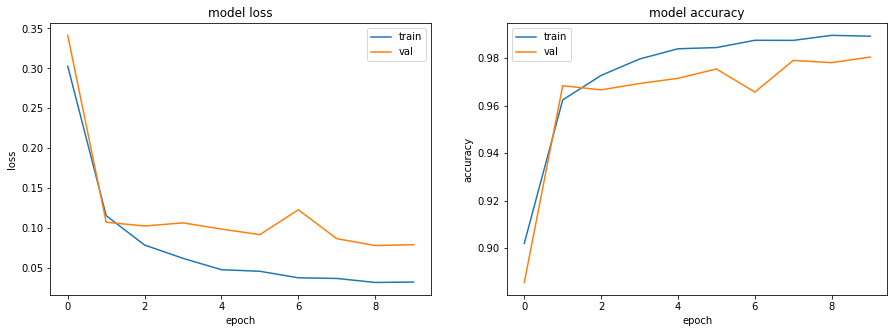

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(cnnhistory.history['loss'])
ax[0].plot(cnnhistory.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper right')
ax[1].plot(cnnhistory.history['accuracy'])
ax[1].plot(cnnhistory.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.show()
fig.savefig('cnn_holdout_beats_loss_and_accuracy.jpg')

### CNN Performance Metrics

Accuracy  : 0.9577952090431292
Precision : 0.823450364108335
Recall : 0.9616945753915673
f1score macro : 0.8762522102963899
f1score micro : 0.9577952090431292


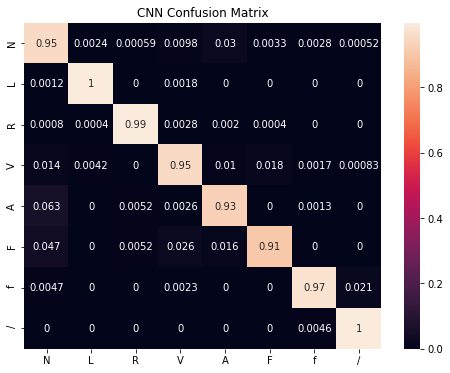

In [19]:
cnn_predict=np.argmax(cnnpredictions,axis=1)
cnn_actual_value=np.argmax(y_test1,axis=1)
cnn_results = showResults(cnn_actual_value, cnn_predict,'CNN')

cnnmetrics = metrics.classification_report(cnn_actual_value, cnn_predict, digits=3)

categories=['N','L','R','V','A','F','f','/']
fig = plt.figure(figsize=(8,6))
cm = confusion_matrix(cnn_actual_value, cnn_predict, normalize='true')
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories)
plt.title('CNN Confusion Matrix')
plt.show()
fig.savefig('cnn_holdout_beats_confusion_matrix_and_metrics_a.jpg', dpi = 400)

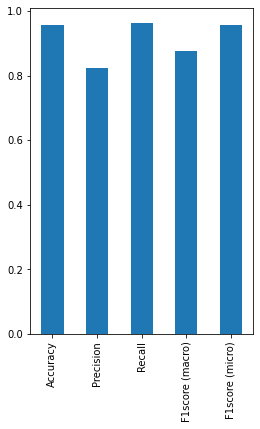

In [20]:
# performance metrics
CNN_results = pd.DataFrame(data=(cnn_results),index=('Model','Accuracy','Precision','Recall','F1score (macro)', 'F1score (micro)','CM'))
fig = plt.figure(figsize=(4,6))
CNN_results[0][1:6].plot(kind='bar')
plt.show()
fig.tight_layout()
fig.savefig('cnn_holdout_beats_confusion_matrix_and_metrics_b.jpg', dpi = 400)

### Save CNN Model, Model weights and results

In [22]:
# #serialize weights to HDF5
if not os.path.exists('./model_weights/'):
    os.mkdir('model_weights')
cnnmodel.save("./model_weights/cnnmodel_beats.h5")
print("Saved model to disk")

#Use only when running on all data
CNN_results = pd.DataFrame(data=cnn_results,index=('Model','Accuracy','Precision','Recall','F1score (macro)', 'F1score (micro)','CM'))
print(CNN_results)

if not os.path.exists('./model_results/'):
    os.mkdir('model_results')
CNN_results.to_csv('./model_results/cnn_beats_results.csv', encoding='utf-8', index=False)

Saved model to disk
                                                                 0
Model                                                          CNN
Accuracy                                                     0.958
Precision                                                    0.823
Recall                                                       0.962
F1score (macro)                                              0.876
F1score (micro)                                              0.958
CM               [[27282, 68, 17, 282, 864, 95, 80, 15], [2, 16...
